# Notebook 9: Feature Correlations

## Purpose
Understand relationships between features and identify multicollinearity issues.

## Key Questions
- Which feature pairs are highly correlated?
- Are there redundant features?
- Which features are most correlated with the target?
- Do correlations change seasonally?
- How do rut features (rut_phase, days_since_rut_start) correlate with other temporal and habitat features?

## Key Observations to Look For
- **High Correlations**: |r| > 0.8 indicates potential redundancy
- **VIF > 10**: Severe multicollinearity problem
- **Target Correlation**: Identifies most predictive features
- **Non-linear Relationships**: May need polynomial terms

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pointbiserialr
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Determine project root and output directories
possible_roots = [
    Path('.'),  # If running from project root
    Path('..'),  # If running from notebooks directory
    Path('../..'),  # If running from subdirectory
]

data_root = None
for root in possible_roots:
    if (root / 'data' / 'features').exists():
        data_root = root / 'data'
        break

if data_root is None:
    data_root = Path('../data')

# Create output directories relative to project root
figures_dir = data_root / 'figures'
reports_dir = data_root / 'reports'
figures_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

print(f'✓ Setup complete')
print(f'  Output directory: {data_root.absolute()}')

✓ Setup complete
  Output directory: /Users/jongalentine/Projects/pathwild/notebooks/../data


## 1. Load Data

This section loads the feature dataset and identifies numeric columns for correlation analysis. Understanding feature relationships is critical for feature selection and avoiding multicollinearity issues in modeling.

In [2]:
# Load data
from pathlib import Path

# Try multiple possible paths
possible_paths = [
    Path('data/features/complete_context.csv'),  # From project root
    Path('../data/features/complete_context.csv'),  # From notebooks directory
    Path('../../data/features/complete_context.csv'),  # From subdirectory
]

data_path = None
for path in possible_paths:
    if path.exists():
        data_path = path
        break

if data_path is None:
    raise FileNotFoundError(
        f'Data file not found. Tried: {[str(p) for p in possible_paths]}\n'
        f'Please run: python scripts/combine_feature_files.py\n'
        f'Or ensure you are running the notebook from the project root directory.'
    )

print(f'Loading data from: {data_path}')
df = pd.read_csv(data_path)

# Detect key columns
# Note: This dataset uses year/month columns, not timestamp
year_col = 'year' if 'year' in df.columns else None
month_col = 'month' if 'month' in df.columns else None
presence_col = None

for col in df.columns:
    if col.lower() in ['presence', 'target', 'label', 'is_presence', 'elk_present']:
        presence_col = col
        break

print(f'Dataset shape: {df.shape}')
print(f'Year column: {year_col}')
print(f'Month column: {month_col}')
print(f'Presence column: {presence_col}')

# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f'Numeric columns: {len(numeric_cols)}')

Loading data from: ../data/features/complete_context.csv
Dataset shape: (431862, 32)
Year column: year
Month column: month
Presence column: elk_present
Numeric columns: 30


## 2. Correlation Matrix

The correlation matrix shows pairwise Pearson correlations between all numeric features. High correlations (|r| > 0.8) indicate potential redundancy where one feature can be predicted from another.

### What This Code Does
- Calculates Pearson correlation coefficient for all feature pairs
- Creates a heatmap visualization with color-coded correlations
- Identifies highly correlated feature pairs (|r| > 0.8)

### Interpreting the Correlation Heatmap

**Color Scale:**
- **Dark red (r = -1.0)**: Perfect negative correlation - as one increases, other decreases
- **White (r = 0.0)**: No linear relationship
- **Dark blue (r = +1.0)**: Perfect positive correlation - both increase together

**Matrix Structure:**
- **Diagonal**: Always +1.0 (feature correlated with itself)
- **Symmetric**: Upper and lower triangles are mirrors
- **Blocks of color**: Groups of related features (e.g., all snow features)

### What to Look For
- **Dark off-diagonal squares**: High correlations requiring attention
- **Feature clusters**: Groups of correlated features (natural groupings)
- **Unexpected correlations**: May indicate data issues or interesting relationships
- **White rows/columns**: Features uncorrelated with others (often valuable)

### Expected High Correlations in Elk Data
- **Temperature features**: temp_max, temp_min, temp_mean highly correlated
- **Snow features**: snow_depth and snow_water_equiv highly correlated
- **Coordinate features**: lat/lon may correlate with elevation
- **Derived features**: Encoded features (cos/sin) with original values

### Implications for Modeling
- **Linear models**: High multicollinearity causes unstable coefficients
- **Tree-based models**: Less affected but redundancy wastes computation
- **Feature selection**: Consider keeping only one from highly correlated pairs

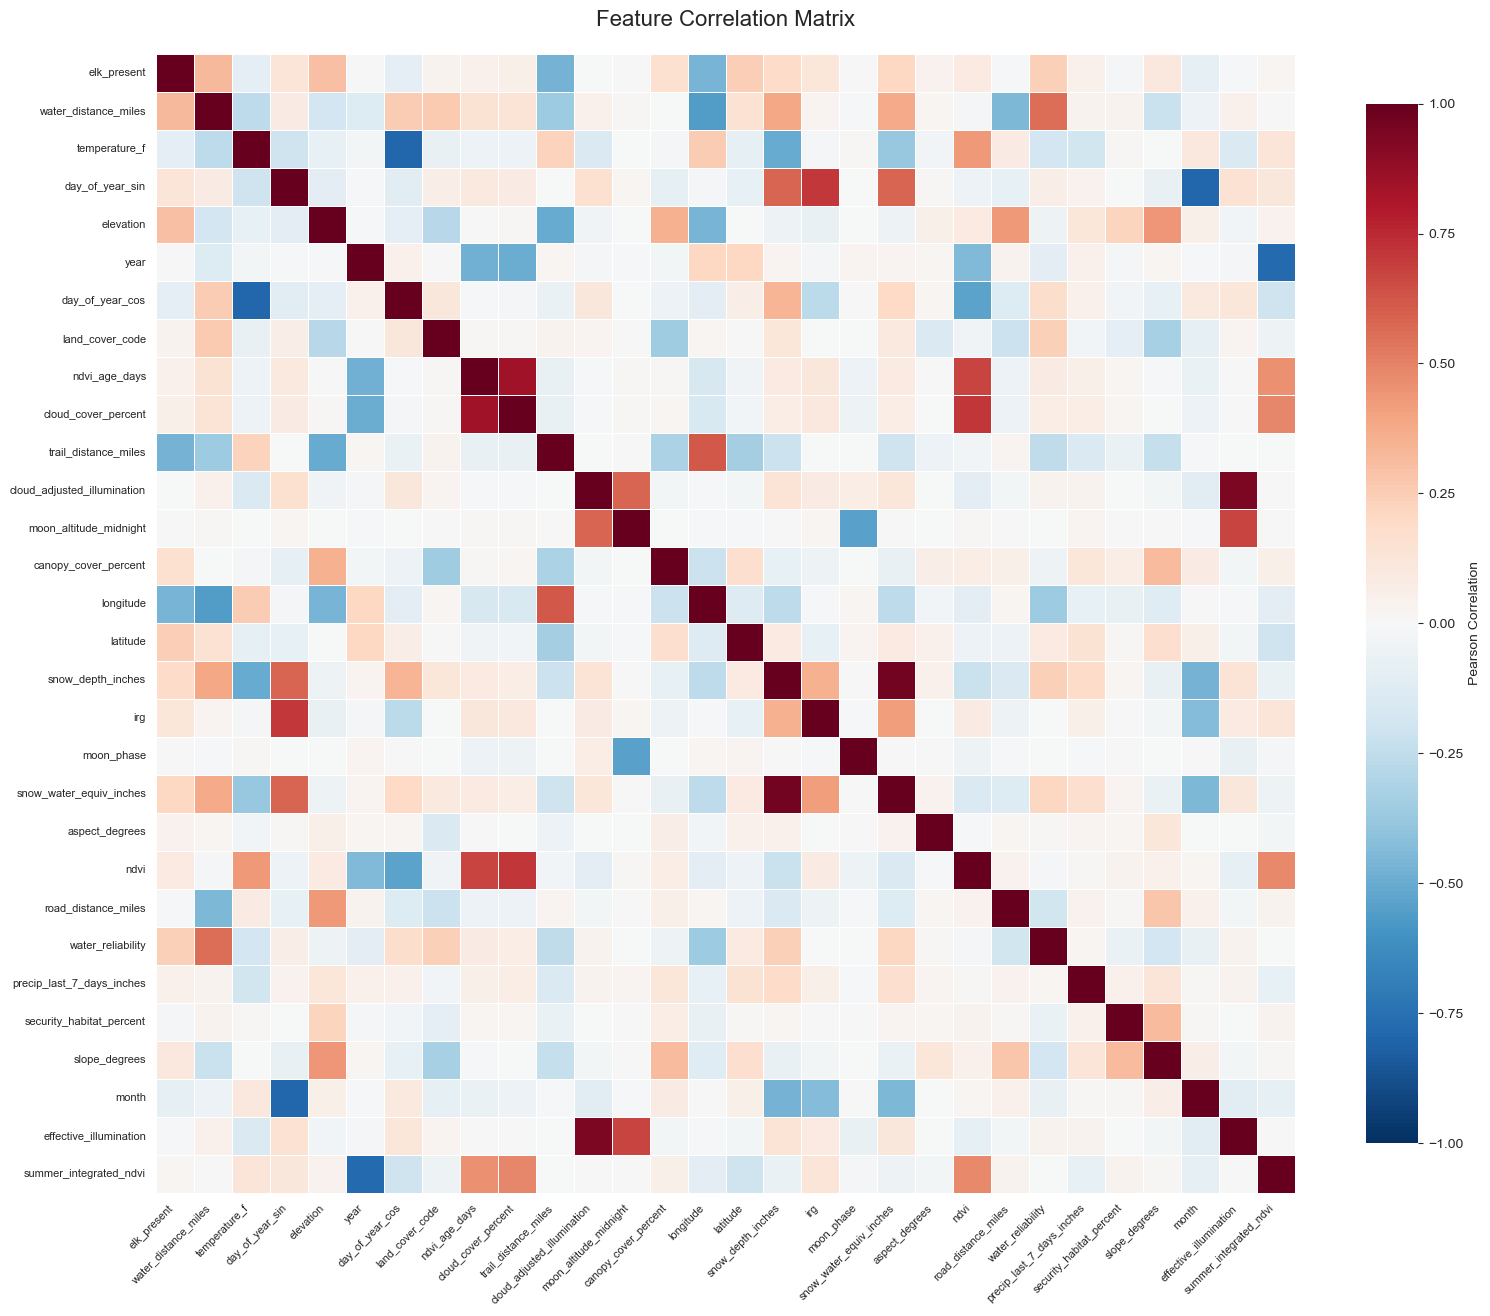

✓ Saved correlation matrix


In [3]:
# Calculate Pearson correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create large annotated heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Pearson Correlation', 'shrink': 0.8}
)
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(figures_dir / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Saved correlation matrix')

In [4]:
# Identify high correlations
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_val
            })

if len(high_corr_pairs) > 0:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', key=abs, ascending=False)
    print(f'\n⚠ Found {len(high_corr_pairs)} feature pairs with |r| > 0.8:')
    print(high_corr_df)
    
    print('\nThese features may be redundant. Consider:')
    print('- Dropping one feature from each pair')
    print('- Using PCA for dimensionality reduction')
    print('- Using regularization (L1/L2) in modeling')
else:
    print('\n✓ No feature pairs with |r| > 0.8 (no severe multicollinearity)')


⚠ Found 3 feature pairs with |r| > 0.8:
                      feature1                 feature2  correlation
2            snow_depth_inches  snow_water_equiv_inches     0.962154
1  cloud_adjusted_illumination   effective_illumination     0.939641
0                ndvi_age_days      cloud_cover_percent     0.851403

These features may be redundant. Consider:
- Dropping one feature from each pair
- Using PCA for dimensionality reduction
- Using regularization (L1/L2) in modeling


## 3. Key Feature Pair Scatter Plots

Scatter plots visualize the relationships between highly correlated feature pairs identified above. This helps verify that correlations are real (not driven by outliers) and understand the nature of relationships.

### What This Code Does
- Creates scatter plots for the top 6 most correlated feature pairs
- Adds regression lines to show linear relationship
- Displays correlation coefficient in title

### Interpreting Scatter Plots

**Pattern Types:**
- **Tight linear band**: Strong linear correlation, features are redundant
- **Scattered cloud with trend**: Moderate correlation, some independent information
- **Curved relationship**: Non-linear correlation (Pearson may underestimate)
- **Clusters**: Distinct groups may indicate categorical variable influence

**Regression Line:**
- **Slope direction**: Positive slope = positive correlation
- **Points near line**: Tight fit confirms strong correlation
- **Points far from line**: Relationship is noisy or non-linear

### What to Look For
- **Outliers driving correlation**: A few extreme points can inflate r
- **Heteroscedasticity**: Spread changing along x-axis indicates non-constant variance
- **Non-linear patterns**: Consider polynomial features or transformations
- **Discrete bands**: May indicate categorical underlying variable

### Decision Points for Redundant Features
When |r| > 0.9, decide which feature to keep based on:
1. **Interpretability**: Which is easier to explain?
2. **Missing data**: Which has fewer missing values?
3. **Target correlation**: Which correlates better with presence/absence?
4. **Domain importance**: Which is more ecologically meaningful?

### Example Decisions
- **temp_max vs temp_mean**: Keep temp_mean (more representative)
- **snow_depth vs snow_water_equiv**: Keep snow_water_equiv (more relevant to movement)
- **latitude vs longitude**: Keep both (different information)

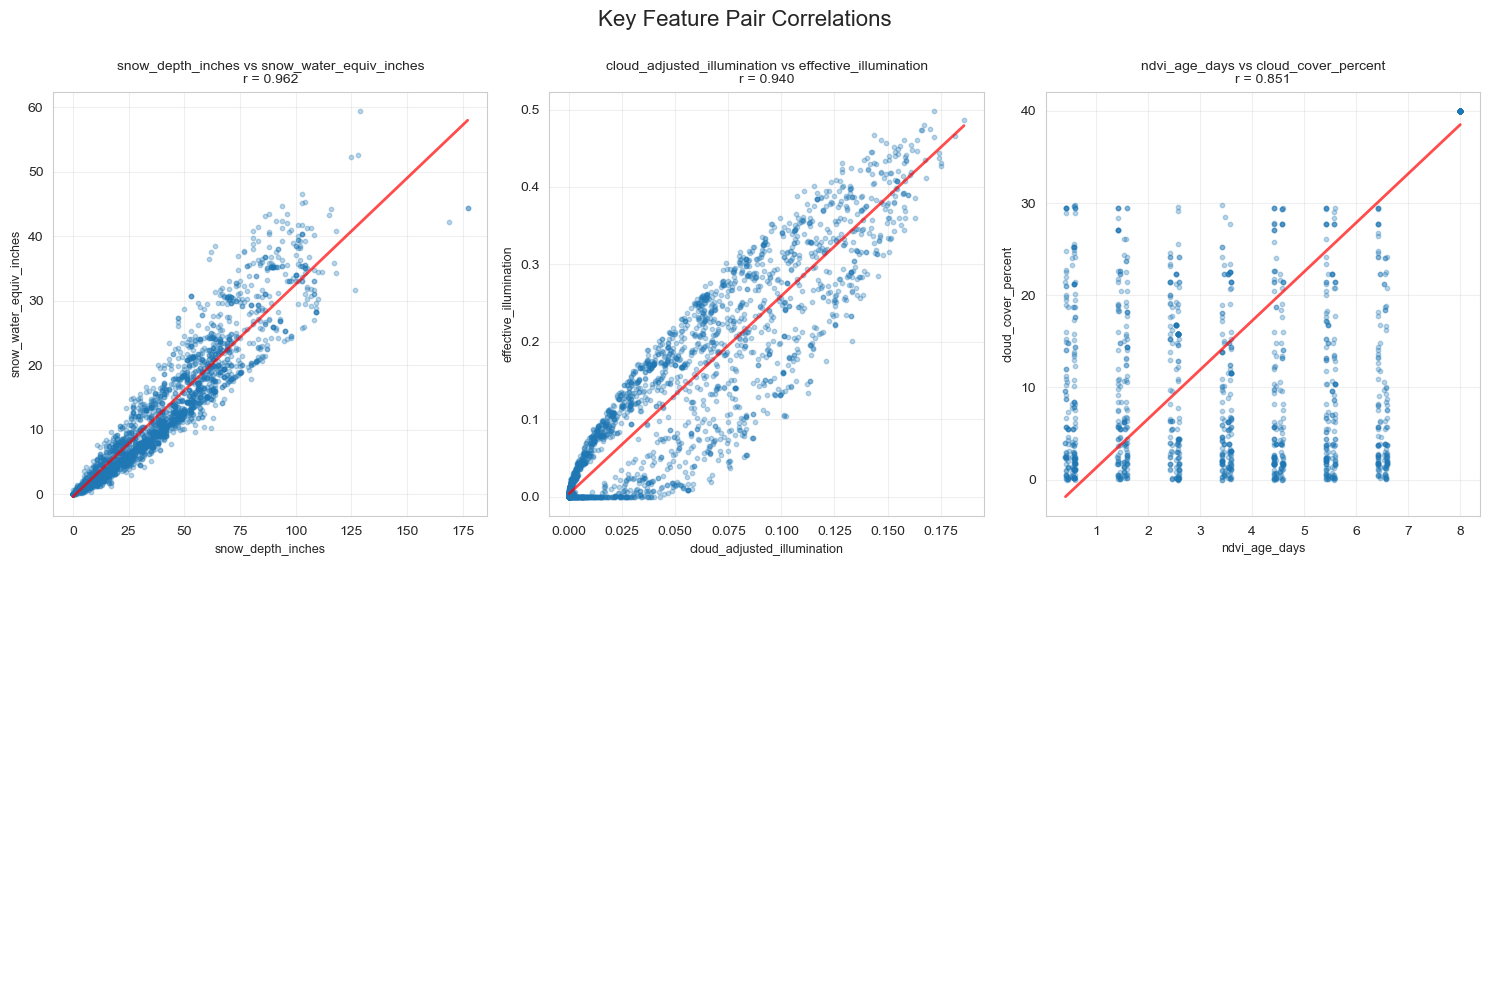

✓ Saved key correlation scatter plots


In [5]:
# Create scatter plots for most correlated pairs
if len(high_corr_pairs) > 0:
    top_pairs = high_corr_df.head(6)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (_, row) in enumerate(top_pairs.iterrows()):
        if idx >= 6:
            break
        
        ax = axes[idx]
        feat1 = row['feature1']
        feat2 = row['feature2']
        corr = row['correlation']
        
        # Sample if too many points
        plot_df = df[[feat1, feat2]].dropna()
        if len(plot_df) > 5000:
            plot_df = plot_df.sample(n=5000, random_state=42)
        
        ax.scatter(plot_df[feat1], plot_df[feat2], alpha=0.3, s=10)
        
        # Add regression line
        z = np.polyfit(plot_df[feat1], plot_df[feat2], 1)
        p = np.poly1d(z)
        x_line = np.linspace(plot_df[feat1].min(), plot_df[feat1].max(), 100)
        ax.plot(x_line, p(x_line), 'r-', linewidth=2, alpha=0.7)
        
        ax.set_xlabel(feat1, fontsize=9)
        ax.set_ylabel(feat2, fontsize=9)
        ax.set_title(f'{feat1} vs {feat2}\nr = {corr:.3f}', fontsize=10)
        ax.grid(alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(top_pairs), 6):
        axes[idx].axis('off')
    
    plt.suptitle('Key Feature Pair Correlations', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'key_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved key correlation scatter plots')
else:
    print('No high correlations to plot')

## 4. Seasonal Correlations

Feature relationships may change across seasons. For example, elevation and temperature might be more strongly correlated in summer than winter. This section examines how the correlation structure varies by season.

### What This Code Does
- Splits data into four seasons (Winter, Spring, Summer, Fall)
- Calculates separate correlation matrices for each season
- Displays four heatmaps side-by-side for comparison

### Interpreting Seasonal Correlation Patterns

**Stable Correlations (same across seasons):**
- Indicates fundamental physical/ecological relationships
- Safe to use in models regardless of season
- Example: elevation-temperature relationship (lapse rate)

**Variable Correlations (change by season):**
- Relationships depend on seasonal context
- May need season-specific models or interaction terms
- Example: snow-elevation correlation (strong in winter, weak in summer)

### What to Look For
- **Winter vs Summer differences**: Most dramatic seasonal contrast
- **Spring/Fall transitions**: May show intermediate patterns
- **Disappearing correlations**: Features related only in certain seasons
- **Sign changes**: Rare but important - relationship reverses by season

### Elk Ecology Context
Seasonal correlation changes reflect elk behavioral shifts:
- **Winter**: Strong correlation between snow and movement constraints
- **Spring**: NDVI-elevation correlation strengthens (green wave)
- **Summer**: More dispersed, weaker spatial correlations
- **Fall**: Rut behavior may change typical correlations

### Implications for Modeling
- **Single model**: May miss seasonal nuances
- **Seasonal models**: Better fit but need more data per season
- **Interaction terms**: Include season × feature interactions
- **Ensemble**: Combine seasonal sub-models

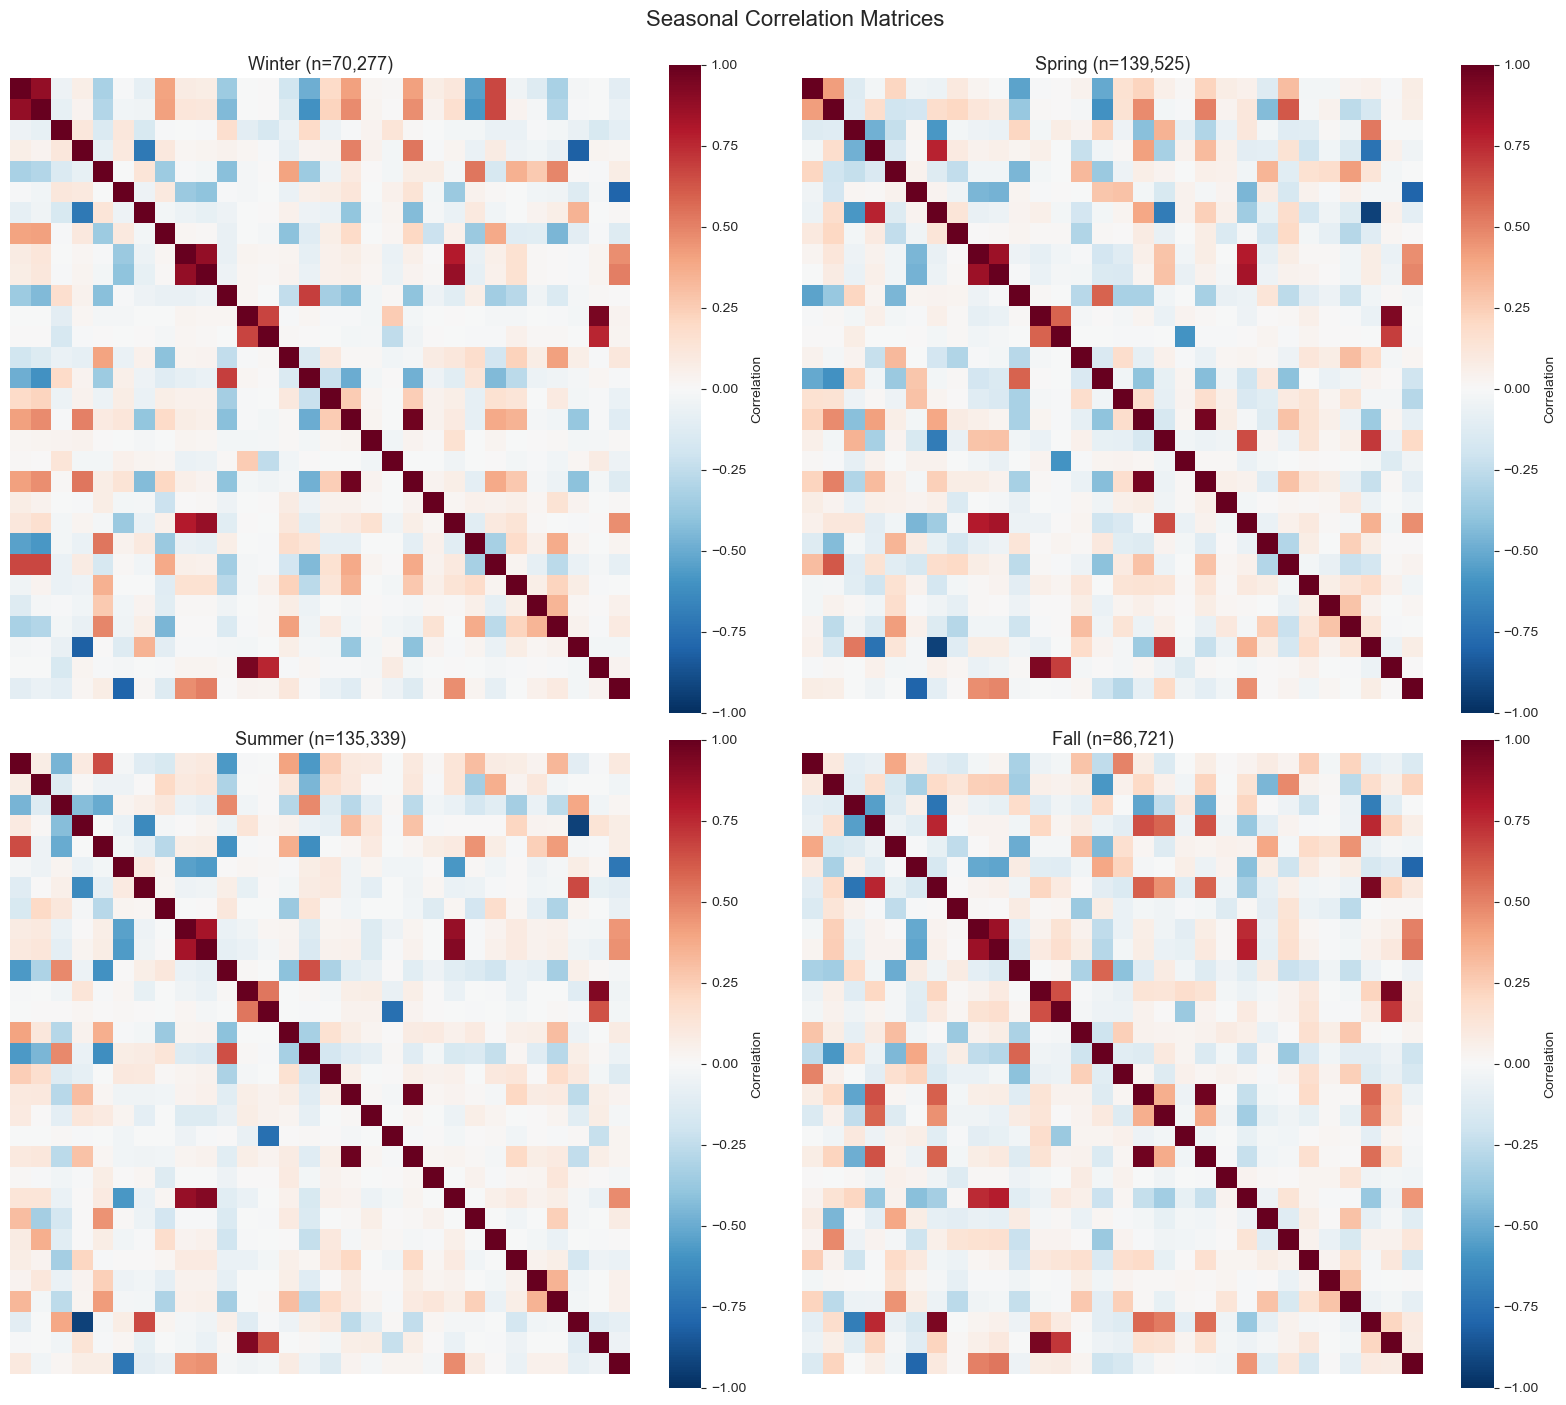

✓ Saved seasonal correlation matrices


In [6]:
# Calculate correlation matrices by season
if month_col and 'month' in df.columns:
    # Define seasons
    seasons = {
        'Winter': [12, 1, 2],
        'Spring': [3, 4, 5],
        'Summer': [6, 7, 8],
        'Fall': [9, 10, 11]
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    
    for idx, (season_name, months) in enumerate(seasons.items()):
        season_df = df[df['month'].isin(months)]
        season_corr = season_df[numeric_cols].corr()
        
        ax = axes[idx]
        sns.heatmap(
            season_corr,
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            cbar_kws={'label': 'Correlation'},
            ax=ax,
            xticklabels=False,
            yticklabels=False
        )
        ax.set_title(f'{season_name} (n={len(season_df):,})', fontsize=13)
    
    plt.suptitle('Seasonal Correlation Matrices', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'seasonal_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved seasonal correlation matrices')
else:
    print('⚠ Cannot analyze seasonal correlations without timestamp column')

## 5. Multicollinearity Detection (VIF)

Variance Inflation Factor (VIF) measures how much each feature's variance is inflated due to correlations with other features. Unlike pairwise correlation, VIF detects multicollinearity involving multiple features simultaneously.

### What This Code Does
- Calculates VIF for each numeric feature
- Creates a horizontal bar chart for easy comparison
- Flags features with VIF > 10 (severe multicollinearity)

### Understanding VIF

**VIF Calculation:**
VIF = 1 / (1 - R²), where R² is from regressing feature on all other features

**VIF Interpretation:**
- **VIF = 1.0**: No correlation with other features (ideal)
- **VIF 1-5**: Low to moderate correlation (acceptable)
- **VIF 5-10**: High correlation (concerning for some models)
- **VIF > 10**: Severe multicollinearity (problematic)
- **VIF = ∞**: Perfect multicollinearity (feature is linear combination of others)

### What to Look For
- **Features with VIF > 10**: Primary candidates for removal
- **Cluster of high VIF**: Related features all inflated together
- **Single high VIF feature**: May be combining information from multiple sources
- **Geographic coordinates**: Often have high VIF due to elevation correlation

### How High VIF Affects Modeling

**Linear Regression:**
- Unstable coefficient estimates (large standard errors)
- Coefficients may have wrong sign
- Small data changes cause large coefficient changes

**Tree-Based Models:**
- Less affected but redundancy splits importance
- May slightly reduce feature importance interpretability
- Generally robust to multicollinearity

### Recommended Actions for High VIF Features
1. **Remove one from correlated pairs**: Keep the more interpretable one
2. **Create composite feature**: Average or PCA combine related features
3. **Use regularization**: L1 (Lasso) or L2 (Ridge) penalizes correlated features
4. **Accept for tree models**: If using Random Forest/XGBoost, high VIF is less critical


Variance Inflation Factors:
                        feature          VIF
12                    longitude  2867.834124
13                     latitude  2374.649649
3                     elevation    65.763595
6                 ndvi_age_days    43.486957
14            snow_depth_inches    37.818599
7           cloud_cover_percent    32.062591
17      snow_water_equiv_inches    29.455272
1                 temperature_f    29.422443
19                         ndvi    27.550899
5               land_cover_code    19.203831
4               day_of_year_cos     7.389800
16                   moon_phase     6.685228
18               aspect_degrees     3.745011
2               day_of_year_sin     3.604730
10       moon_altitude_midnight     3.330281
0          water_distance_miles     3.324114
9   cloud_adjusted_illumination     3.306959
8          trail_distance_miles     2.767170
15                          irg     2.609907
11         canopy_cover_percent     1.983134


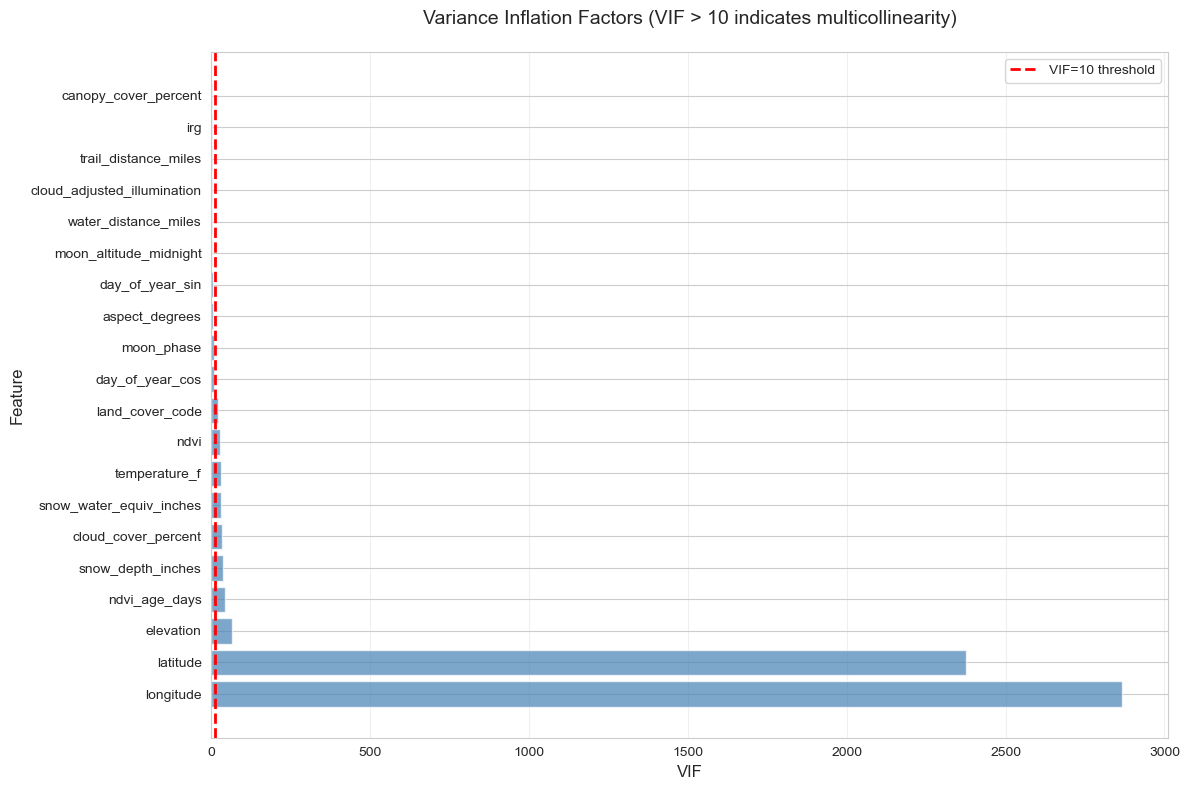


✓ Saved VIF analysis

⚠ WARNING: 10 features with VIF > 10:
  - longitude: VIF = 2867.83
  - latitude: VIF = 2374.65
  - elevation: VIF = 65.76
  - ndvi_age_days: VIF = 43.49
  - snow_depth_inches: VIF = 37.82
  - cloud_cover_percent: VIF = 32.06
  - snow_water_equiv_inches: VIF = 29.46
  - temperature_f: VIF = 29.42
  - ndvi: VIF = 27.55
  - land_cover_code: VIF = 19.20


In [7]:
# Calculate Variance Inflation Factor
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    # Select features for VIF (exclude target, timestamps, etc.)
    vif_features = [col for col in numeric_cols 
                   if col not in [presence_col, 'month', 'year']][:20]  # Limit for performance
    
    vif_data = df[vif_features].dropna()
    
    if len(vif_data) > 0:
        vif_results = []
        
        for i, col in enumerate(vif_features):
            try:
                vif = variance_inflation_factor(vif_data.values, i)
                vif_results.append({'feature': col, 'VIF': vif})
            except:
                vif_results.append({'feature': col, 'VIF': np.nan})
        
        vif_df = pd.DataFrame(vif_results).sort_values('VIF', ascending=False)
        
        print('\nVariance Inflation Factors:')
        print(vif_df)
        
        # Plot VIF
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(vif_df)), vif_df['VIF'], color='steelblue', alpha=0.7)
        plt.axvline(10, color='red', linestyle='--', linewidth=2, label='VIF=10 threshold')
        plt.yticks(range(len(vif_df)), vif_df['feature'])
        plt.xlabel('VIF', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Variance Inflation Factors (VIF > 10 indicates multicollinearity)', fontsize=14, pad=20)
        plt.legend()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(figures_dir / 'vif_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print('\n✓ Saved VIF analysis')
        
        # Flag high VIF
        high_vif = vif_df[vif_df['VIF'] > 10]
        if len(high_vif) > 0:
            print(f'\n⚠ WARNING: {len(high_vif)} features with VIF > 10:')
            for _, row in high_vif.iterrows():
                print(f"  - {row['feature']}: VIF = {row['VIF']:.2f}")
        else:
            print('\n✓ No features with VIF > 10')
    else:
        print('⚠ Insufficient data for VIF calculation')
        
except ImportError:
    print('⚠ statsmodels not available for VIF calculation')
except Exception as e:
    print(f'⚠ Could not calculate VIF: {e}')

## 6. Target Correlation

The most important correlations for predictive modeling are between features and the target variable (elk presence/absence). This section ranks features by their correlation with the binary target.

### What This Code Does
- Calculates point-biserial correlation (appropriate for binary target)
- Ranks features by absolute correlation with presence/absence
- Creates a bar chart showing positive (green) and negative (red) correlations

### Understanding Point-Biserial Correlation

For binary targets (0/1), point-biserial correlation is equivalent to Pearson correlation and ranges from -1 to +1:
- **Positive (green bars)**: Higher values → higher presence probability
- **Negative (red bars)**: Higher values → lower presence probability

### Interpreting Target Correlations

**Correlation Strength:**
- **|r| > 0.3**: Strong predictor (rare for individual features)
- **|r| 0.1-0.3**: Moderate predictor (typical for useful features)
- **|r| < 0.1**: Weak predictor (may still contribute in ensemble)

**Direction Examples for Elk:**
- **NDVI (+)**: Higher vegetation = more presence (forage)
- **Slope (-)**: Steeper terrain = less presence (energy cost)
- **Water distance (-)**: Farther from water = less presence
- **Road distance (+)**: Farther from roads = more presence (avoidance)

### What to Look For
- **Top features**: Best candidates for parsimonious models
- **Sign direction**: Verify ecological intuition
- **Unexpected strong correlations**: May indicate data issues or discoveries
- **Weak correlations for expected features**: May indicate data quality issues

### Using Target Correlations for Feature Selection
1. **Start with top 10**: Build baseline model with strongest predictors
2. **Add incrementally**: Add features and check for improved performance
3. **Remove redundant**: If two features have similar target correlation AND high mutual correlation, keep one
4. **Consider interactions**: Low-correlation features may be powerful in combinations


Feature correlation with target:
                      feature  correlation        p_value  abs_correlation
9        trail_distance_miles    -0.472072   0.000000e+00         0.472072
13                  longitude    -0.461289   0.000000e+00         0.461289
0        water_distance_miles     0.326909   0.000000e+00         0.326909
3                   elevation     0.303683   0.000000e+00         0.303683
14                   latitude     0.247739   0.000000e+00         0.247739
22          water_reliability     0.237310   0.000000e+00         0.237310
18    snow_water_equiv_inches     0.203817   0.000000e+00         0.203817
15          snow_depth_inches     0.193062   0.000000e+00         0.193062
12       canopy_cover_percent     0.158432   0.000000e+00         0.158432
2             day_of_year_sin     0.127940   0.000000e+00         0.127940
16                        irg     0.123613   0.000000e+00         0.123613
25              slope_degrees     0.105355   0.000000e+00         

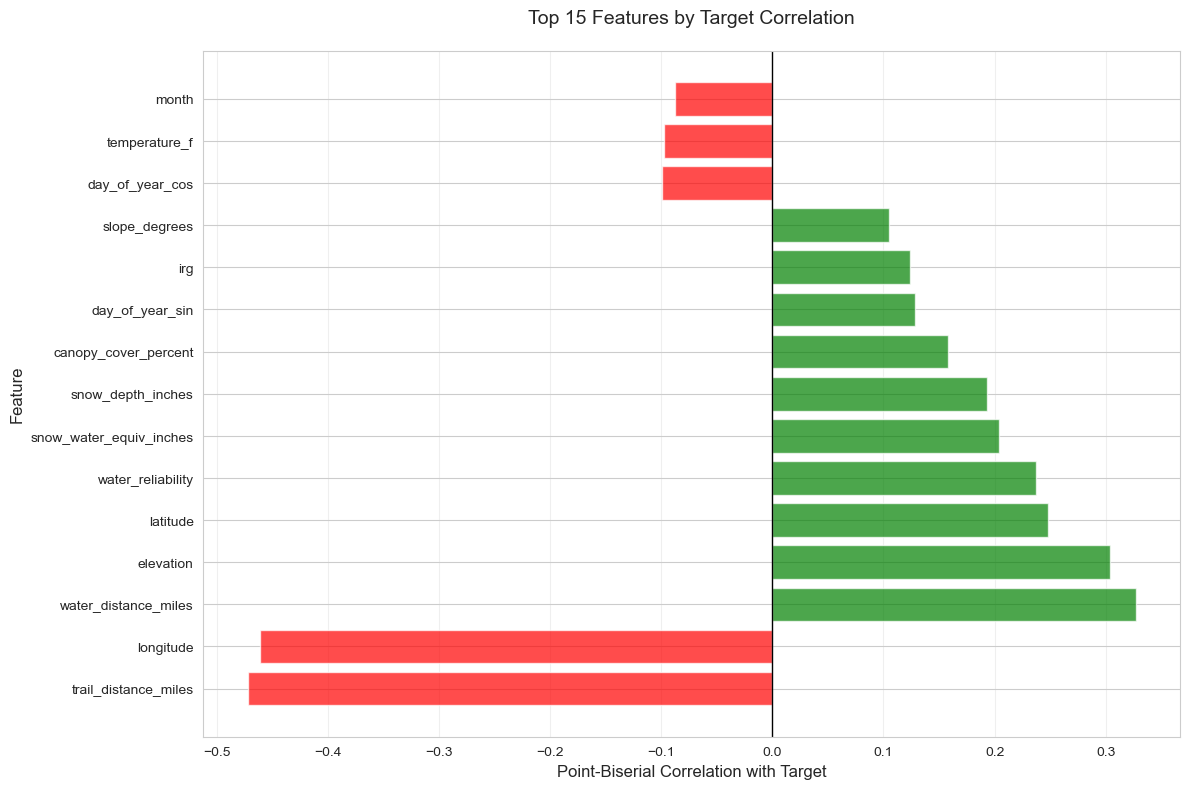


✓ Saved target correlation plot

Top 10 most correlated features with target:
  - trail_distance_miles: r = -0.472, p = 0.00e+00
  - longitude: r = -0.461, p = 0.00e+00
  - water_distance_miles: r = 0.327, p = 0.00e+00
  - elevation: r = 0.304, p = 0.00e+00
  - latitude: r = 0.248, p = 0.00e+00
  - water_reliability: r = 0.237, p = 0.00e+00
  - snow_water_equiv_inches: r = 0.204, p = 0.00e+00
  - snow_depth_inches: r = 0.193, p = 0.00e+00
  - canopy_cover_percent: r = 0.158, p = 0.00e+00
  - day_of_year_sin: r = 0.128, p = 0.00e+00


In [8]:
# Calculate correlation with target variable
if presence_col:
    target_corr = []
    
    for col in numeric_cols:
        if col != presence_col:
            # Use point-biserial correlation for binary target
            data = df[[col, presence_col]].dropna()
            
            if len(data) > 0:
                try:
                    corr, p_value = pointbiserialr(data[presence_col], data[col])
                    target_corr.append({
                        'feature': col,
                        'correlation': corr,
                        'p_value': p_value,
                        'abs_correlation': abs(corr)
                    })
                except:
                    pass
    
    if len(target_corr) > 0:
        target_corr_df = pd.DataFrame(target_corr).sort_values('abs_correlation', ascending=False)
        
        print('\nFeature correlation with target:')
        print(target_corr_df.head(20))
        
        # Plot top correlations
        top_n = min(15, len(target_corr_df))
        top_corr = target_corr_df.head(top_n)
        
        plt.figure(figsize=(12, 8))
        colors = ['green' if x > 0 else 'red' for x in top_corr['correlation']]
        plt.barh(range(len(top_corr)), top_corr['correlation'], color=colors, alpha=0.7)
        plt.yticks(range(len(top_corr)), top_corr['feature'])
        plt.xlabel('Point-Biserial Correlation with Target', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'Top {top_n} Features by Target Correlation', fontsize=14, pad=20)
        plt.axvline(0, color='black', linewidth=1)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(figures_dir / 'target_correlations.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print('\n✓ Saved target correlation plot')
        
        # Identify top predictive features
        print(f'\nTop 10 most correlated features with target:')
        for _, row in target_corr_df.head(10).iterrows():
            print(f"  - {row['feature']}: r = {row['correlation']:.3f}, p = {row['p_value']:.2e}")
    else:
        print('⚠ Could not calculate target correlations')
else:
    print('⚠ Cannot calculate target correlation without presence column')

## 7. Non-linear Relationships

Pearson correlation only measures linear relationships. Important predictors may have non-linear relationships with presence probability (e.g., optimal elevation range). This section visualizes potential non-linear patterns.

### What This Code Does
- Creates scatter plots of top features vs presence (with jitter)
- Adds binned mean lines showing how presence rate varies across feature range
- Reveals non-linear patterns like optimal ranges or thresholds

### Interpreting Non-linear Pattern Plots

**Linear Pattern (diagonal line):**
- Presence rate increases/decreases monotonically
- Linear models appropriate
- Pearson correlation captures relationship well

**Quadratic/Dome Pattern:**
- Presence peaks at intermediate values
- Optimal range exists (e.g., ideal elevation band)
- Add squared term or use tree-based model

**Threshold Pattern:**
- Presence rate jumps at specific value
- Hard boundary effect (e.g., snow depth limit)
- Consider binning or threshold features

**Flat Pattern with Endpoints:**
- Feature matters only at extreme values
- May need transformation or interaction

### What to Look For
- **NDVI**: Should show positive relationship (more green = more presence)
- **Elevation**: May show dome shape (optimal range for each season)
- **Snow depth**: Likely threshold effect (too deep limits movement)
- **Distance features**: Usually monotonic decline with distance

### Implications for Feature Engineering
1. **Polynomial terms**: Add feature² for dome-shaped relationships
2. **Binned features**: Convert continuous to categorical for threshold effects
3. **Log transform**: For features with diminishing returns
4. **Tree-based models**: Automatically capture non-linearity

### Elk Ecology Context
Non-linear relationships reflect biological reality:
- **Elevation**: Elk prefer 7,000-9,000 ft (trade-off forage vs climate)
- **Slope**: Slightly prefer gentle slopes, but use steep for escape
- **Snow**: Tolerable up to ~20 inches, then strongly avoid
- **Temperature**: Prefer moderate temperatures, avoid extremes

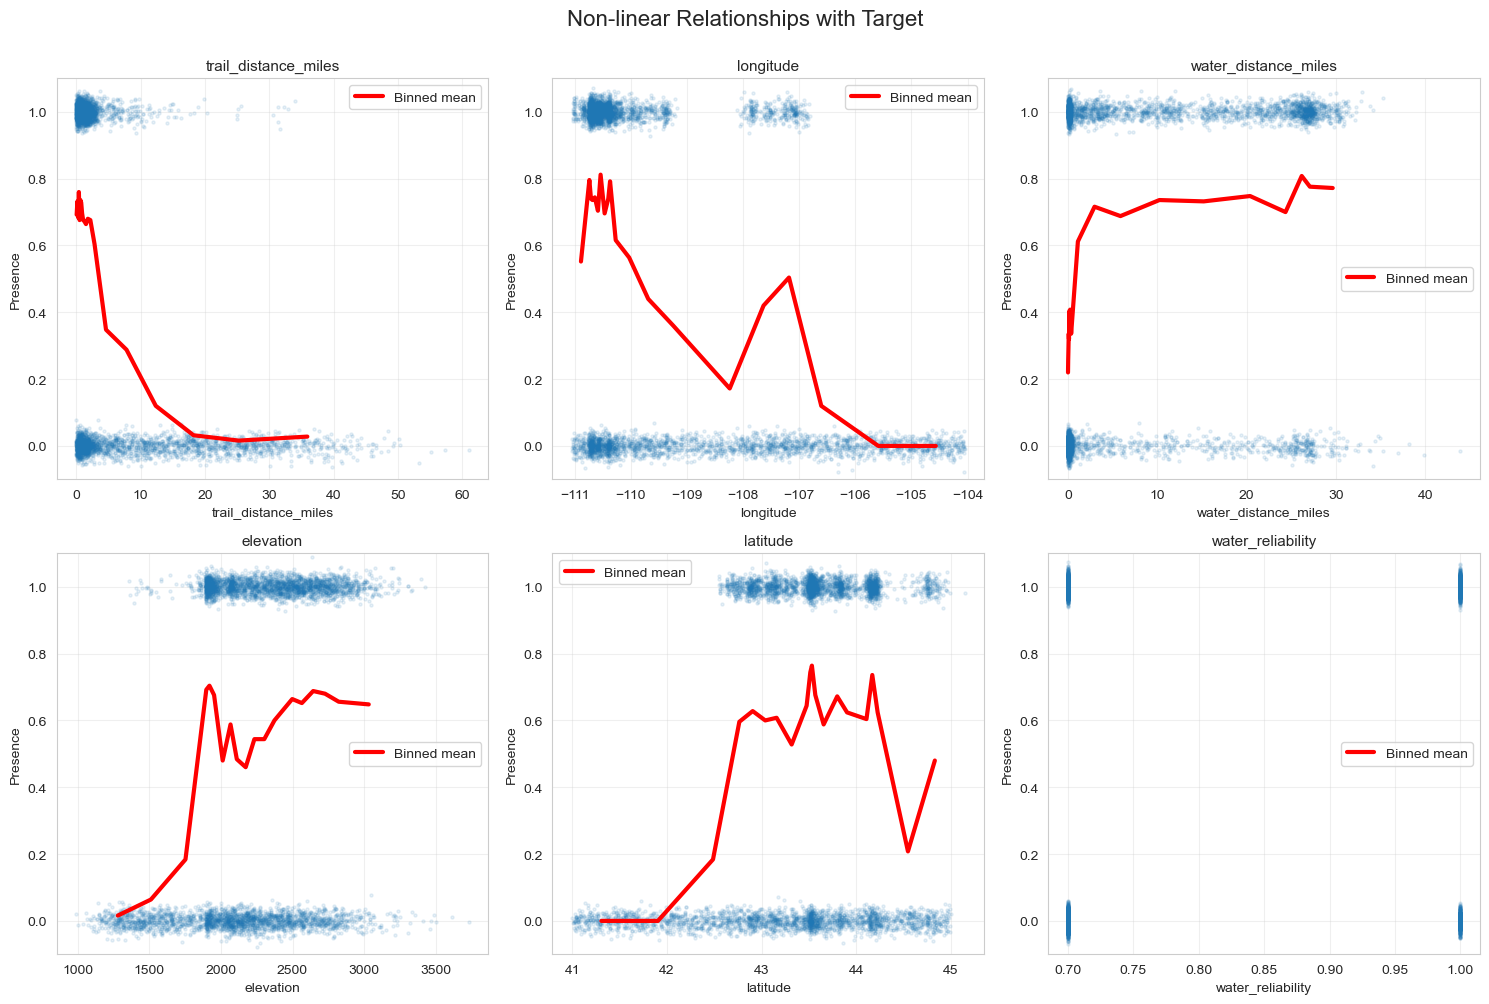

✓ Saved non-linear relationship plots


In [9]:
# Examine non-linear relationships with target
if presence_col and len(target_corr) > 0:
    top_features = target_corr_df.head(6)['feature'].tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, feat in enumerate(top_features):
        ax = axes[idx]
        
        # Sample data
        plot_df = df[[feat, presence_col]].dropna()
        if len(plot_df) > 5000:
            plot_df = plot_df.sample(n=5000, random_state=42)
        
        # Scatter plot with jitter on y-axis
        jitter = np.random.normal(0, 0.02, len(plot_df))
        ax.scatter(plot_df[feat], plot_df[presence_col] + jitter, alpha=0.1, s=5)
        
        # Add LOESS smoothing
        try:
            from scipy.interpolate import UnivariateSpline
            
            # Sort by feature value
            sorted_df = plot_df.sort_values(feat)
            
            # Bin and calculate mean presence rate
            n_bins = 20
            bins = pd.qcut(sorted_df[feat], n_bins, duplicates='drop')
            binned = sorted_df.groupby(bins)[presence_col].mean()
            bin_centers = sorted_df.groupby(bins)[feat].mean()
            
            ax.plot(bin_centers, binned, 'r-', linewidth=3, label='Binned mean')
        except:
            pass
        
        ax.set_xlabel(feat, fontsize=10)
        ax.set_ylabel('Presence', fontsize=10)
        ax.set_title(f'{feat}', fontsize=11)
        ax.set_ylim(-0.1, 1.1)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.suptitle('Non-linear Relationships with Target', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'nonlinear_relationships.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved non-linear relationship plots')
else:
    print('⚠ Cannot analyze non-linear relationships')

## 8. Correlation Summary

This section compiles all correlation analysis findings into a summary report with actionable recommendations for feature selection and modeling.

### What This Code Does
- Summarizes high correlation pairs and their implications
- Lists top predictive features by target correlation
- Saves detailed correlation reports to CSV files

### Using the Summary Reports

**correlation_analysis.csv:**
- Lists all feature pairs with |r| > 0.8
- Use to decide which features to drop or combine
- Review before final feature selection

**target_correlations.csv:**
- Ranks all features by predictive power
- Use for feature selection prioritization
- Compare before/after data pipeline changes

### Next Steps After Correlation Analysis
1. **Remove redundant features**: One from each highly correlated pair
2. **Address high VIF**: Apply recommended transformations
3. **Verify ecological sense**: Check that correlations match expectations
4. **Plan feature engineering**: Create polynomial/interaction terms as needed
5. **Proceed to Notebook 10**: Validate heuristic scores

In [10]:
# Create comprehensive correlation summary
summary = {
    'high_correlations': len(high_corr_pairs) if len(high_corr_pairs) > 0 else 0,
    'features_analyzed': len(numeric_cols)
}

if presence_col and len(target_corr) > 0:
    summary['top_predictive_features'] = target_corr_df.head(10)['feature'].tolist()
    summary['strongest_correlation'] = target_corr_df.iloc[0]['correlation']

print('\n' + '='*70)
print('CORRELATION ANALYSIS SUMMARY')
print('='*70)
print(f"\nFeatures analyzed: {summary['features_analyzed']}")
print(f"High correlation pairs (|r|>0.8): {summary['high_correlations']}")

if 'top_predictive_features' in summary:
    print(f"\nTop 10 predictive features:")
    for i, feat in enumerate(summary['top_predictive_features'], 1):
        corr_val = target_corr_df[target_corr_df['feature']==feat].iloc[0]['correlation']
        print(f"  {i:2d}. {feat}: r = {corr_val:.3f}")

print('\n' + '='*70)

# Save correlation analysis report
if len(high_corr_pairs) > 0:
    high_corr_df.to_csv(reports_dir / 'correlation_analysis.csv', index=False)
    print(f'\n✓ Saved correlation analysis to {reports_dir / "correlation_analysis.csv"}')

if presence_col and len(target_corr) > 0:
    target_corr_df.to_csv(reports_dir / 'target_correlations.csv', index=False)
    print(f'✓ Saved target correlations to {reports_dir / "target_correlations.csv"}')


CORRELATION ANALYSIS SUMMARY

Features analyzed: 30
High correlation pairs (|r|>0.8): 3

Top 10 predictive features:
   1. trail_distance_miles: r = -0.472
   2. longitude: r = -0.461
   3. water_distance_miles: r = 0.327
   4. elevation: r = 0.304
   5. latitude: r = 0.248
   6. water_reliability: r = 0.237
   7. snow_water_equiv_inches: r = 0.204
   8. snow_depth_inches: r = 0.193
   9. canopy_cover_percent: r = 0.158
  10. day_of_year_sin: r = 0.128


✓ Saved correlation analysis to ../data/reports/correlation_analysis.csv
✓ Saved target correlations to ../data/reports/target_correlations.csv


## Summary

This notebook analyzed feature correlations:

1. **Correlation Matrix**: Identified highly correlated feature pairs
2. **Key Pairs**: Visualized strongest correlations
3. **Seasonal Correlations**: Examined how relationships change by season
4. **Multicollinearity (VIF)**: Flagged features with VIF > 10
5. **Target Correlation**: Ranked features by predictive power
6. **Non-linear Relationships**: Identified features needing polynomial terms

**Key Findings**:
- Review `data/reports/correlation_analysis.csv` for redundant features
- Review `data/reports/target_correlations.csv` for feature selection
- Consider dropping one feature from highly correlated pairs
- Use regularization to handle multicollinearity

**Recommendations**:
- Features with VIF > 10 should be dropped or combined
- Top correlated features are good candidates for modeling
- Non-linear relationships may benefit from feature engineering

**Next Steps**:
- Proceed to Notebook 10 for heuristic validation